In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import multivariate_normal
import scipy.optimize as opt

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [23]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_val = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split data into train and validation sets
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
def train_NET(trainloader,
              learning_rate,
              activation_function = nn.ReLU(),
              epochs = 1,
              n_neurons=[[3072,512],[512,258],[258,10]],
              criterion = nn.CrossEntropyLoss(),
              verbose=True):
    
    # Define the neural network model
    class MLP(nn.Module):
        def __init__(self, n_neurons, activation_function):
            
            # Initialize the MLP model
            super().__init__()
                
            # List to store layers
            layers = []

            # Input layer
            layers.append(nn.Linear(n_neurons[0][0], n_neurons[0][1]))
            layers.append(activation_function)
            
            # Hidden layers
            for i in range(1, len(n_neurons)):
                layers.append(nn.Linear(n_neurons[i][0], n_neurons[i][1]))
                layers.append(activation_function)

            # Create the Sequential container
            self.linear_layers = nn.Sequential(*layers)

        def forward(self, x):
            batch_size = x.shape[0]
            # Flatten x
            x = x.view(batch_size, -1)
            # Apply linear 
            out = self.linear_layers(x)

            return out

    net = MLP(n_neurons, activation_function)
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    for epoch in range(int(epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if verbose and i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

        if verbose:
            print(f'Epoch [{epoch + 1}/{epochs}] Loss: {running_loss / len(trainloader):.3f}')

    print('Finished Training')
    return net 

def evaluate_NET(net, validloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return 1.0 - accuracy

In [25]:
# Define hyperparameter space
activation_f = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
learning_rate_values = [0.0001, 0.001, 0.1]

n_test = 5
n_sample = 6
n_wu = 2
            
hyperparameters = {
    "learning_rate": learning_rate_values
}

number_of_hyperparameters = len(list(hyperparameters.keys()))

In [26]:
def mu(k, K, y):
    return k.T @ K @ y

def sigma(Kx, k, K):
    return Kx - k.T @ K @ k

def kernel_M52(x1, x2, l=None, s=1):
    if l is None:
        l = np.ones(len(x1))
    # check if l and x have the same dimension
    if len(x1) != len(l):
        raise ValueError('Dimension of x and l must be the same')
    r2 = np.sum(((x1-x2)/l)**2)
    return np.abs(s)*(1 + np.sqrt(5*r2) + (5/3)*r2)*np.exp(-np.sqrt(5*r2))
        
def generate_combinations(dictionary):
    keys = list(dictionary.keys())
    value_lists = [dictionary[key] for key in keys]
    combinations = list(itertools.product(*value_lists))
    return combinations

In [27]:
# Expected improvement 
def acq_func_EI(y_best, mu, sigma):
    # initialize standard normal distribution
    stand_norm = multivariate_normal(mean=[0], cov=[[1]])
    epsilon = 1e-6  # Small epsilon value to prevent division by zero
    z = (y_best - mu) / (sigma + epsilon)
    return (z*stand_norm.cdf(z) + stand_norm.pdf(z)) * sigma

In [28]:
# Define the negative log likelihood function to minimize
def negative_log_likelihood(params, data, X):
    # construct Covariance matrix
    cov_matrix = np.zeros((len(data),len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            cov_matrix[i, j] = kernel_M52(X[:, i], X[:, j], params[:-1], params[-1])

    log_likelihood = 0.5* ((data).T) @ np.linalg.inv(cov_matrix) @ data + 0.5*np.log(np.linalg.det(cov_matrix)) + 0.5*len(data)*np.log(2*np.pi)
    return log_likelihood

In [40]:
def bayes_optimization_max_likelihood(hyp_space,
                                        n_sample,
                                        n_wu,
                                        acq_function, 
                                        kernel,

                                        opt_iter,
                                        opt_bounds,

                                        eval_func,
                                        train_func,
                                        train_loader,
                                        val_loader ):

    y_best_vec = np.array([])
    best_hyp = np.array([])
    y_sampled = np.array([])
    hyp_name = list(hyp_space.keys())
    y_best = np.inf
    
    thetas = []
    neg_log_liks = []
    
    # all possible combinations of hyperparameters (each row is a combination)
    hyp_space_combinations = np.array(generate_combinations(hyp_space))

    # Warm up phase

    # random sampling from hyperparameter space
    # matrix of sampled values (rows: hyperparameters, columns: samples)
    x_sampled = np.zeros((len(hyp_name), n_sample+n_wu))
    for j in range(n_wu):
        print(f"Warm-up sample {j+1}/{n_wu}...")
        # sample hyperparameters from the hyperparameter space
        np.random.shuffle(hyp_space_combinations)
        x_sampled[:, j] = hyp_space_combinations[0]
        # delete the sampled value from the hyperparameter combinations 
        hyp_space_combinations = np.delete(hyp_space_combinations, 0, axis=0)
        # evaluate function
        trained_model = train_func(train_loader, *x_sampled[:, j])
        y = eval_func(trained_model, val_loader)
        y_sampled = np.append(y_sampled, y)
        # update y_best
        if y < y_best:
            y_best = y
            best_hyp = x_sampled[:, j]
        # append y_best to y_best_vec
        y_best_vec = np.append(y_best_vec, y_best)
    print("Warm-up phase completed.")

    # initialize the values of hyper-hyper params
    theta = np.ones(len(x_sampled[:, 0])+1)
    
    # sampling phase
    print("Sampling phase...")
    for j in range(n_wu, n_sample+n_wu):
        acq_max = -np.inf
        print(f"Sample {j+1}/{n_sample+n_wu}:")

        K = np.zeros((j,j))
        for i in range(j):
            for l in range(j):
                # The kernel makes an assumption on the covariance
                # Update every new sample
                K[i, l] = kernel(x_sampled[:, i], x_sampled[:, l], theta[:-1], theta[-1])

        neg_log_likelihood = 0.5* ((y_sampled).T) @ np.linalg.inv(K) @ y_sampled + 0.5*np.log(np.linalg.det(K)) + 0.5*len(y_sampled)*np.log(2*np.pi)
        neg_log_liks.append(neg_log_likelihood)
        print("Calculated log_likelihood:", neg_log_likelihood)

        K_inv = np.linalg.inv(K)

        acquisitions = []

        for idx, xs in enumerate(hyp_space_combinations):
            
            # compute the kernel vector for each combination of hyperparameter
            # with the newly chosen HP
            k = np.array([kernel(x_sampled[:, l], xs, theta[:-1], theta[-1]) for l in range(j)])
            
            # Compute the acquisition function using mu and sigma functions
            acq = acq_function(y_best, 
                               mu(k, K_inv, y_sampled),
                               sigma(kernel(xs, xs, theta[:-1], theta[-1]),     k, K_inv))

            # Keep all acq values for every combination of hyperparameters
            acquisitions.append(acq)
            
            # check if the new value is the maximum
            if acq > acq_max:
                acq_max = acq
                tmp_x_sampled = xs
                idx_to_del = idx
        
        # plot the acquisition function vs all the combinations of hyperparameters
        # and highlight the maximum
        plt.plot(acquisitions)
        plt.scatter(np.argmax(acquisitions), acq_max, c='r', label="Maximum")
        plt.title("Acquisition function")
        plt.xlabel("Hyperparameter combinations")
        plt.ylabel("Acquisition function value")
        plt.show()
    
        # update x_sampled
        x_sampled[:, j] = tmp_x_sampled
        print(f"Trying hyperparameters: {x_sampled[:, j]}")
        # delete the sampled value from the hyperparameter combinations  
        #hyp_space_combinations = np.delete(hyp_space_combinations, np.where((hyp_space_combinations == tmp_x_sampled).all(axis=1))[0][0], axis=0)
        hyp_space_combinations = np.delete(hyp_space_combinations, idx_to_del, axis=0)

        # evaluate function
        trained_model = train_func(train_loader, *x_sampled[:, j])
        y = eval_func(trained_model,val_loader)
        y_sampled = np.append(y_sampled, y)
        # update y_best
        if y < y_best:
            y_best = y
            best_hyp = x_sampled[:, j]

        # append y_best to y_best_vec
        y_best_vec = np.append(y_best_vec, y_best)

        print("Begin optimization of hyper-hyperparameters...")
        theta_tryouts = []
        init_thetas = np.random.normal(1, 9, (opt_iter,len(theta)))
        for theta in init_thetas:
            # Perform hyperhyper paramet optimization
            result = opt.minimize(negative_log_likelihood,
                                theta, 
                                args=(y_sampled,x_sampled), method='L-BFGS-B',
                                options = {'maxiter': 10000, 'disp': True}, bounds= opt_bounds)
            theta_tryouts.append(result.x)

        max_freq_thetas = []
        for sample in np.array(theta_tryouts).T:
            # calculate the np histogram of the sample
            hist, bins = np.histogram(sample, bins=100)
            # find the value of the bin with the highest frequency
            max_freq_thetas.append(bins[np.argmax(hist)])

        print("Chosen hyper-hyper parameters:",max_freq_thetas)

        # plot histograms of the hyperhyperparameters
        fig, axs = plt.subplots(1, len(theta), figsize=(8, 4))
        for i in range(len(theta)):
            axs[i].hist(np.array(theta_tryouts)[:, i], bins=100)
            axs[i].set_title(f"theta_{i+1}")
        plt.tight_layout()
        plt.show()

        thetas.append(max_freq_thetas)

    return best_hyp, y_best_vec, x_sampled, y_sampled, neg_log_liks, thetas

Warm-up sample 1/2...
Epoch [1/1] Loss: 196.791
Finished Training
Warm-up sample 2/2...
Epoch [1/1] Loss: 751.683
Finished Training
Warm-up phase completed.
Sampling phase...
Sample 3/13:
Calculated log_likelihood: -0.4478072216417588


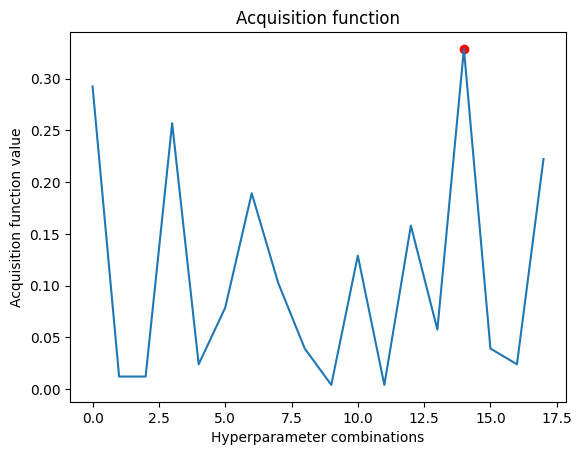

Trying hyperparameters: [1.]
Epoch [1/1] Loss: 14769.953
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [9.8, 0.30819950017520475]


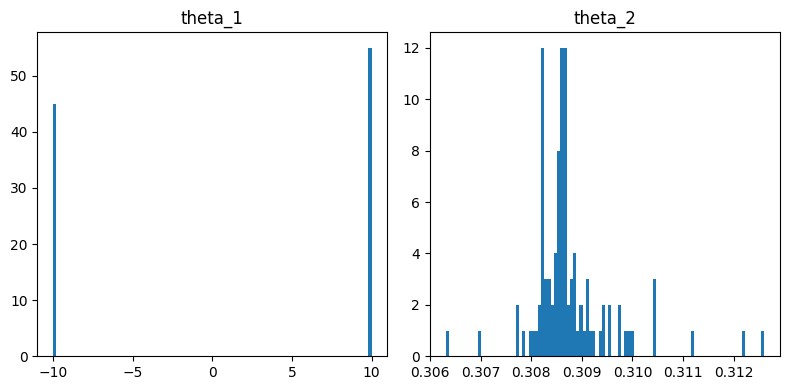

Sample 4/13:
Calculated log_likelihood: 1.8965837076790066


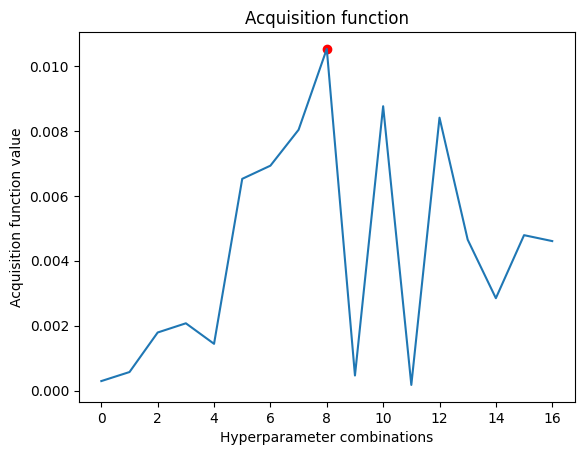

Trying hyperparameters: [1.e-05]
Epoch [1/1] Loss: 2.115
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [0.5932683467011675, 0.4735105344189025]


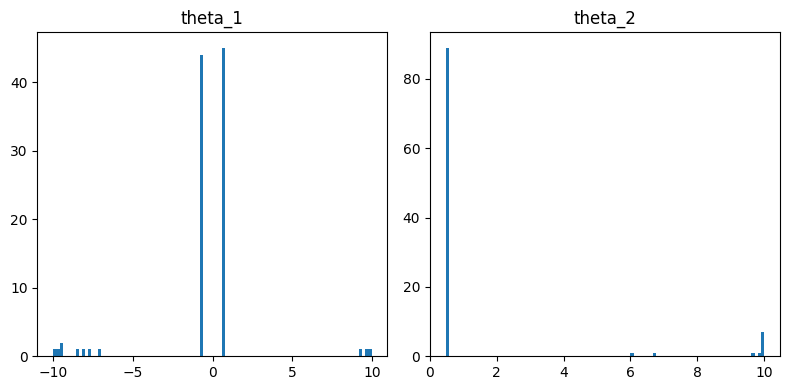

Sample 5/13:
Calculated log_likelihood: 881.7766923732386


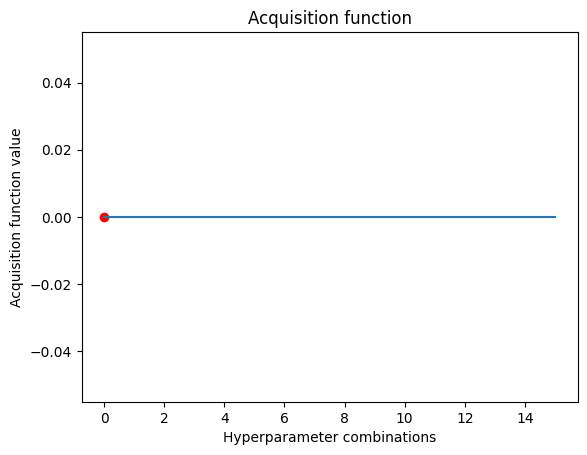

Trying hyperparameters: [0.94736895]
Epoch [1/1] Loss: 18565.134
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [0.6000000000000014, 0.4296841865883904]


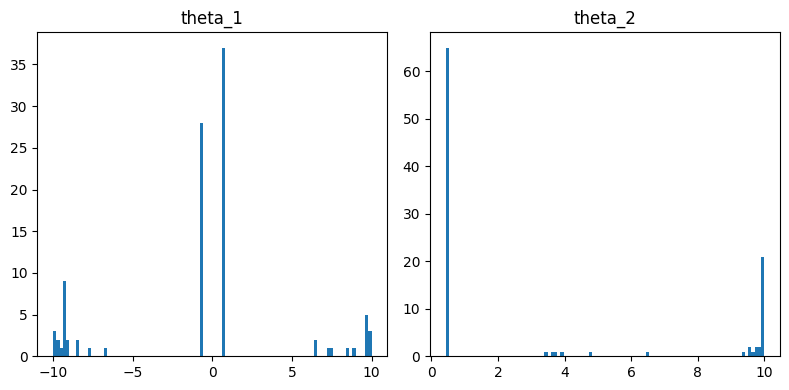

Sample 6/13:
Calculated log_likelihood: 493.1823338894928


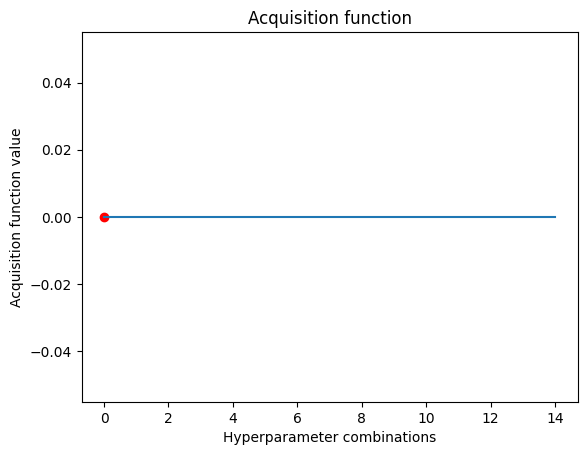

Trying hyperparameters: [0.36842737]
Epoch [1/1] Loss: 703.157
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [0.6000000000000014, 0.44330301634292973]


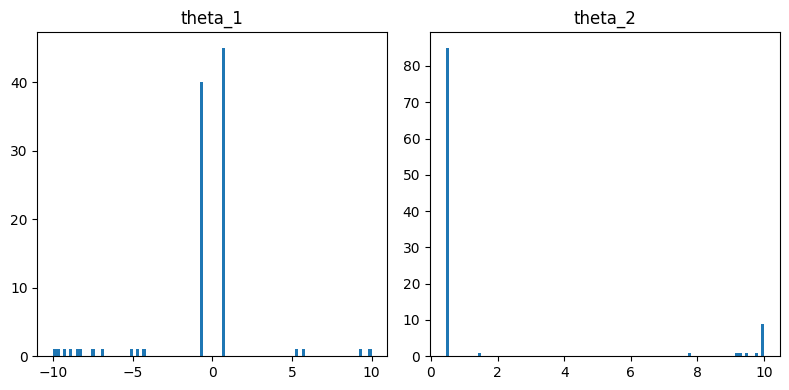

Sample 7/13:
Calculated log_likelihood: 96.35807954414238


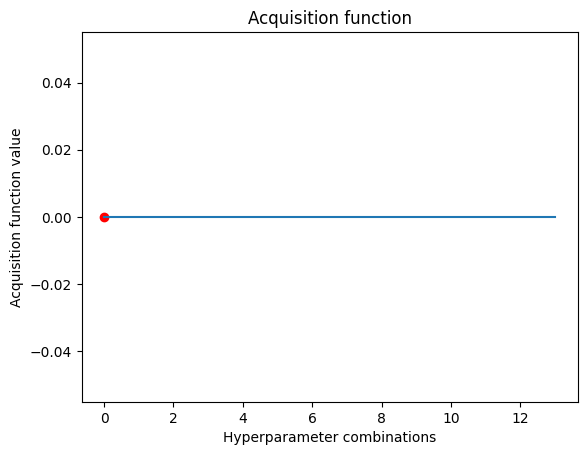

Trying hyperparameters: [0.10527211]
Epoch [1/1] Loss: 21.209
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5930138372017524, 0.4581870104595946]


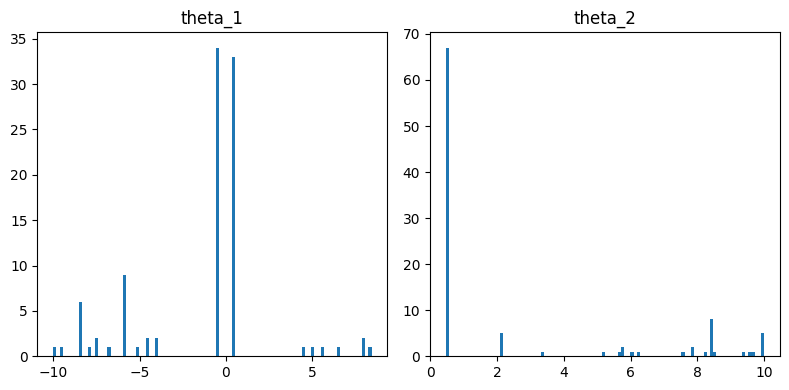

Sample 8/13:
Calculated log_likelihood: 1351.1638357233721


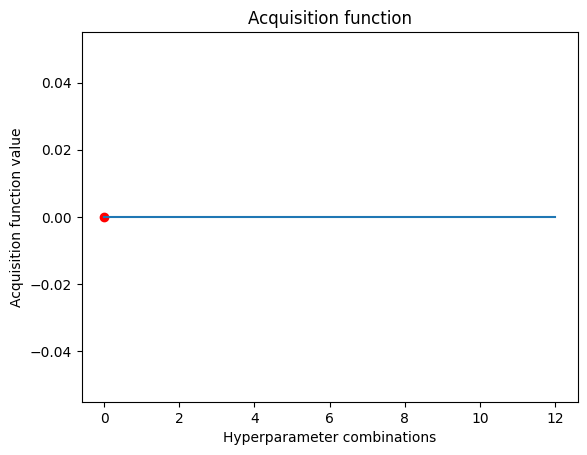

Trying hyperparameters: [0.89473789]
Epoch [1/1] Loss: 19061.621
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5999999999999996, 0.3963765828440111]


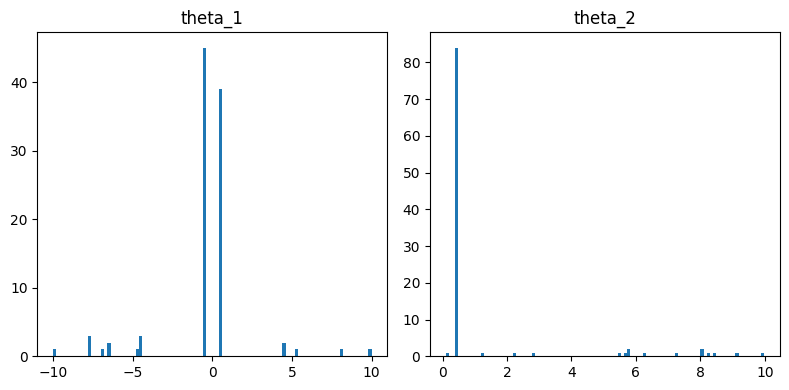

Sample 9/13:
Calculated log_likelihood: 161919.5160430511


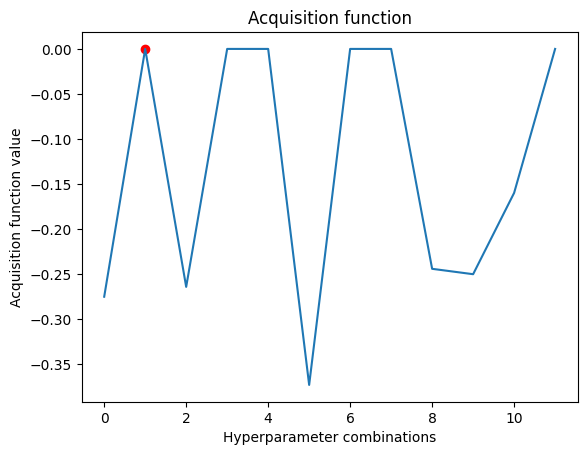

Trying hyperparameters: [0.57895158]
Epoch [1/1] Loss: 1342.808
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5999999999999996, 0.397]


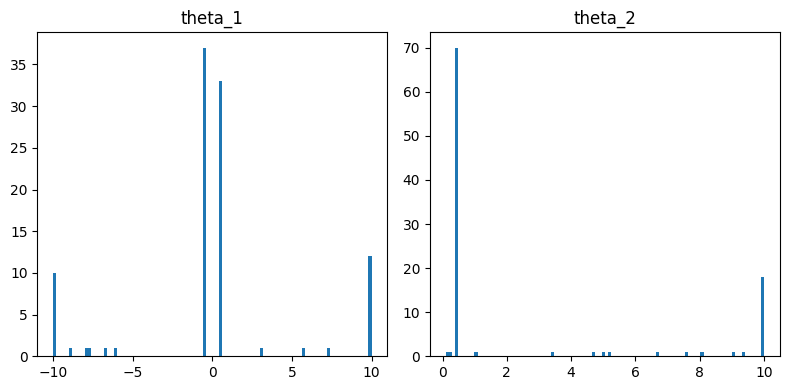

Sample 10/13:
Calculated log_likelihood: 63.63024812706745


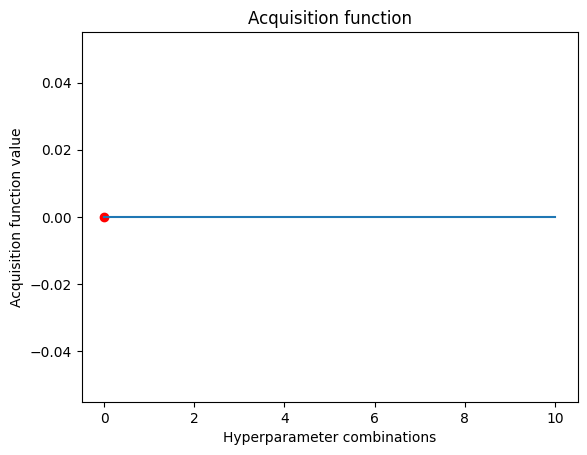

Trying hyperparameters: [0.42105842]
Epoch [1/1] Loss: 1539.080
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5999999999999996, 0.397]


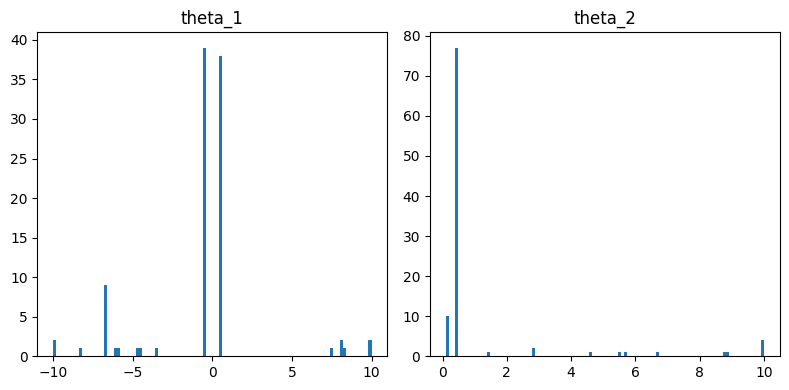

Sample 11/13:
Calculated log_likelihood: -5.3419056793740545


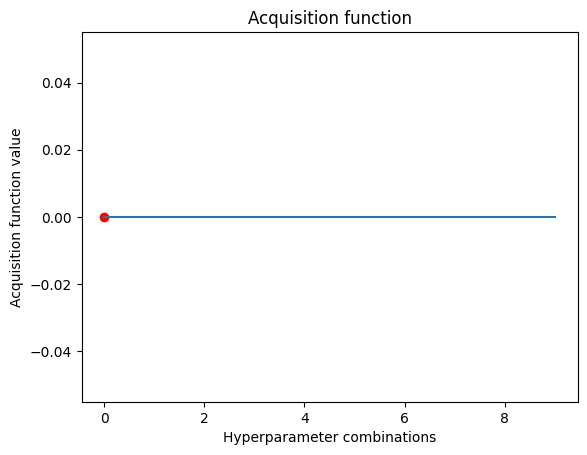

Trying hyperparameters: [0.78947579]
Epoch [1/1] Loss: 5811.623
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5608978689723632, 0.5152281899362311]


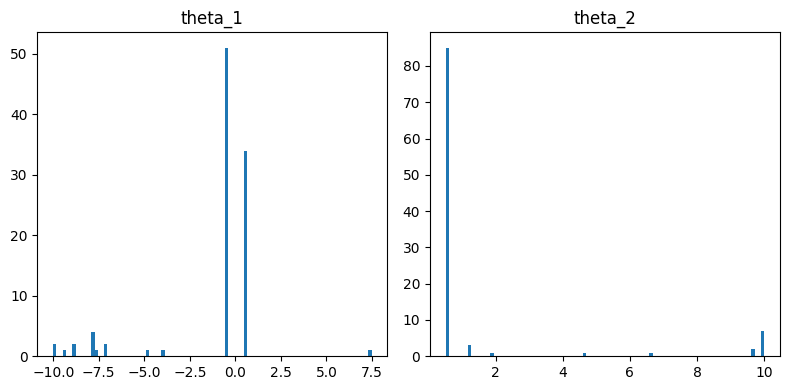

Sample 12/13:
Calculated log_likelihood: 932.9081176683336


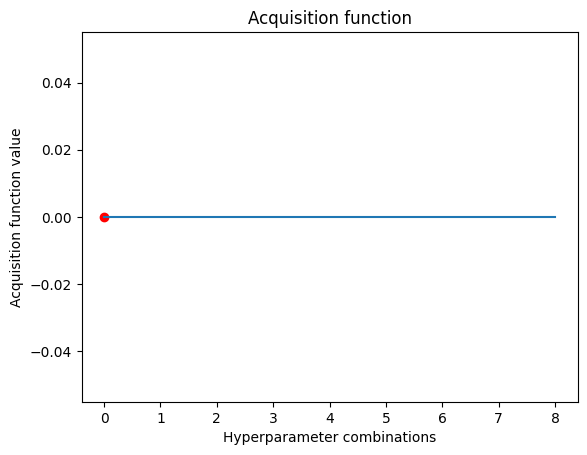

Trying hyperparameters: [0.63158263]
Epoch [1/1] Loss: 3692.511
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5971080444918808, 0.496]


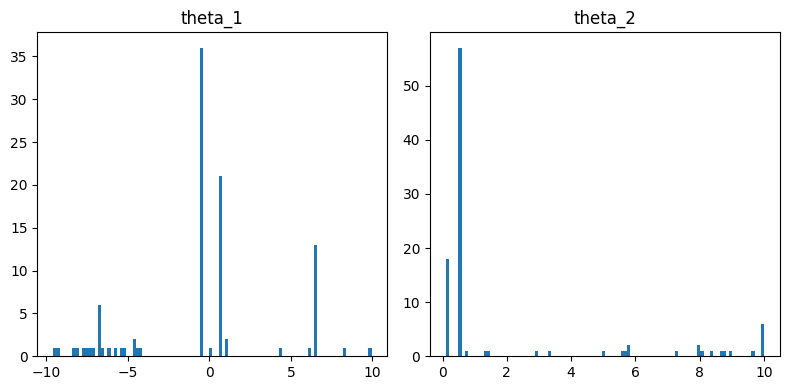

Sample 13/13:
Calculated log_likelihood: 1104157.3305414487


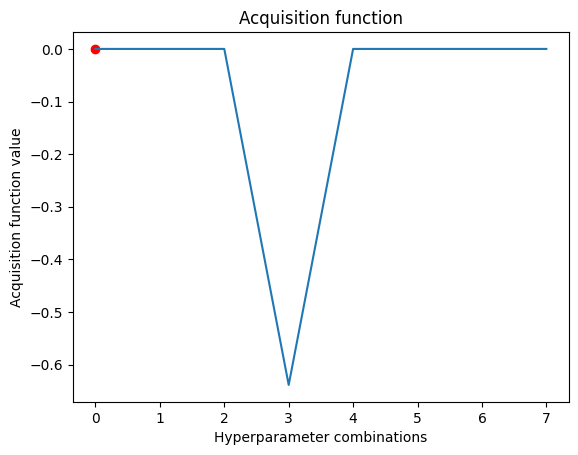

Trying hyperparameters: [0.15790316]
Epoch [1/1] Loss: 66.895
Finished Training
Begin optimization of hyper-hyperparameters...
Chosen hyper-hyper parameters: [-0.5999999999999996, 0.496]


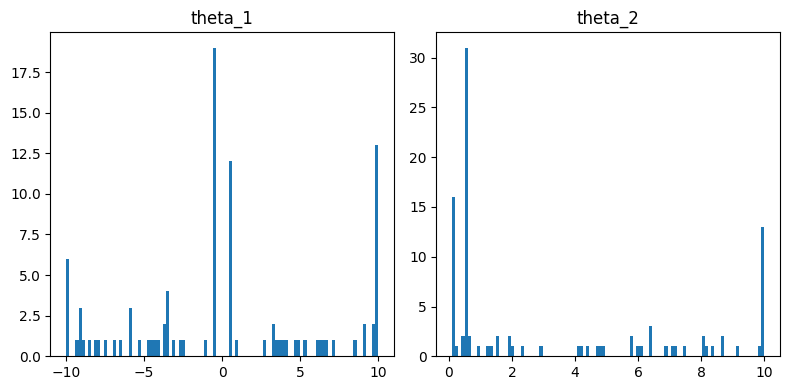

In [41]:
n_wu = 2
n_sample = 11

# Define hyperparameter space
learning_rate_values = np.linspace(1e-5,1,20)
hyperparameters = {"learning_rate": learning_rate_values}

# hyper-hyper-hyperparameters
opt_iter = 100
opt_bounds = [(-10,10), (0.1, 10)]

# Optimize hyperparameters
best_hyp, y_best_vec, x_sampled, y_sampled, neg_log_liks, thetas = bayes_optimization_max_likelihood(
                                                                    hyperparameters,
                                                                    n_sample,
                                                                    n_wu,
                                                                    acq_func_EI,
                                                                    kernel_M52,
                                                                    opt_iter,
                                                                    opt_bounds,
                                                                    evaluate_NET,
                                                                    train_NET,
                                                                    train_loader,
                                                                    val_loader)

In [42]:
thetas = np.array(thetas)
print("Best hyperparameters: ", best_hyp)

Best hyperparameters:  [1.e-05]


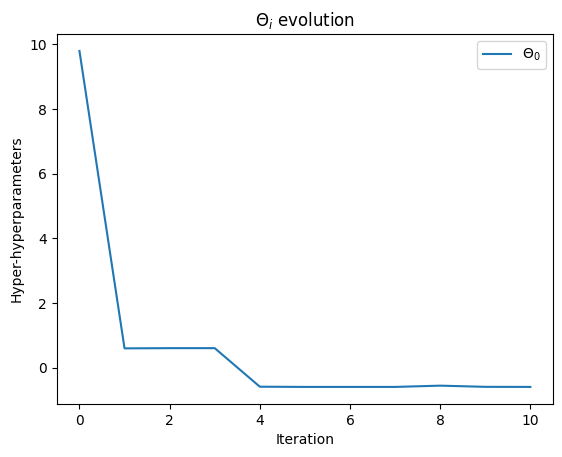

In [43]:
#plot hyper-hyperparameters evolution
plt.plot(thetas[:, :-1])
plt.title(f'$\Theta_i$ evolution')
plt.xlabel('Iteration')
plt.ylabel('Hyper-hyperparameters')
plt.legend([f'$\Theta_{i}$' for i in range(len(thetas[0]))])
plt.show()

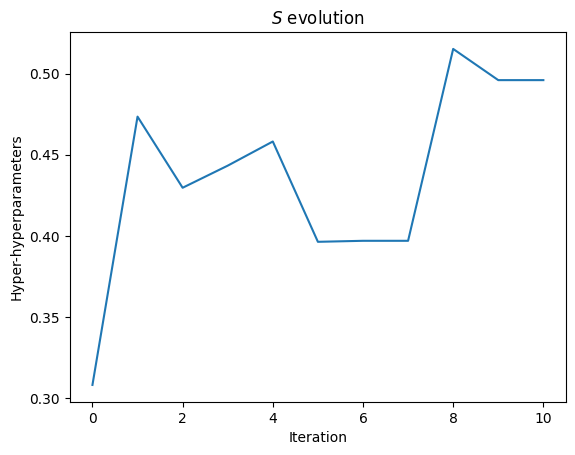

In [44]:
#plot hyper-hyperparameters evolution
#plt.plot([i[5] for i in thetas])
plt.plot(thetas[:, -1])
plt.title(f'$S$ evolution')
plt.xlabel('Iteration')
plt.ylabel('Hyper-hyperparameters')
plt.show()

Text(0.5, 1.0, 'Loss evolution')

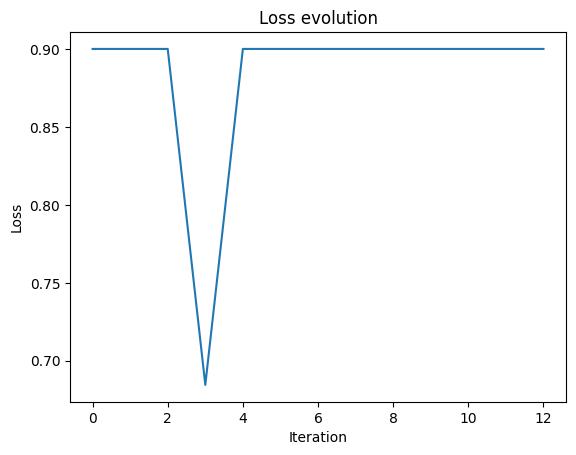

In [45]:
# plot the samples losses
plt.plot(y_sampled)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss evolution')

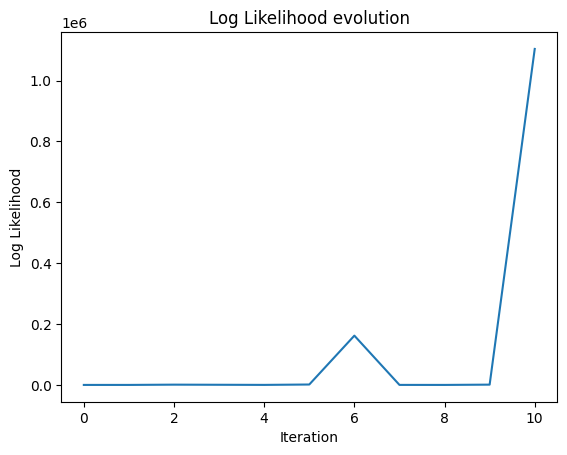

In [47]:
# plot log_liks
plt.plot(neg_log_liks)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood evolution')
plt.show()